In [42]:
import numpy as np
import scipy.linalg as lin
import matplotlib.pyplot as plt

%matplotlib notebook

In [43]:
## In this cell, I will define the tight-binding parameters

t0 = 0.0
t1 = 5.5
t2 = 0.006
t3 = 0.001

# 1. Build the Hamiltonian:

### 1.1 Hamiltonian blocks

**The matrix blocks are as follows:**


1.$D_{n{n}'}=\left \langle{n}\mid D\mid {n}' \right \rangle=t_{0} \frac{2\hbar^{2}}{l_{B}^{2}}(n+\frac{1}{2})\delta _{n{n}'}$

2.$F_{n{n}'}=\left \langle{n}\mid F\mid{n}' \right \rangle=\left [ t_{1}q_{z}+t_{2}q_{z}\frac{2\hbar^{2}}{l_{B}^{2}}(n+\frac{1}{2})\right ]\delta _{n{n}'}$

3.

$G_{n{n}'}=\left \langle{n}\mid G\mid{n}' \right \rangle=-t_{s}\frac{4\hbar^{3}}{(l_{B}\sqrt{2})^{3}}\left [ \sqrt{({n}'+1)({n}'+2)({n}'+3)}\delta _{n,{n}'+3}-\sqrt{({n}')({n}'-1)({n}'-2)}\delta _{n,{n}'-3}\right ]$  

$G_{n{n}'}^{\dagger }= -G_{n{n}'}$

  
4.Operator relations:
$$
\begin{align}
\Pi_{x}=\Pi_{x}^{\dagger } \\
\Pi_{y}=\Pi_{y}^{\dagger }
\end{align}
$$

In [44]:
def KDelta(n, m, offset=0):
    """
    This function return the Kronecker Delta function.
    
    Input: n, m(this is n prime in the handwritting notation), offset: this is a integer
    
    return: 1 if the condition is satisfied, otherwise 0
    """
    if (n == m+offset):
        return 1;
    else:
        return 0;
    

def Dele(n, m):
    """
    This function return the D element as the handwritting shows
    
    Input: n and m, two integers indicate the matrix index
    Output: D function
    """
    return t0*(n+0.5)*KDelta(n,m)

def Fele(kz, n, m):
    """
    This function return the F element as the handwritting shows
    
    Input: n and m, two integers indicate the matrix index
    Output: F function
    """
    return (t1*kz+t2*kz*(n+0.5))*KDelta(n,m)

def Gele(n, m):
    """
    This function return the G element as the handwritting shows
    
    Input: n and m, two integers indicate the matrix index
    Output: G function
    """
#     return (-t3/np.sqrt(2))*(np.sqrt(n*(n-1)*(n-2))*KDelta(n-3,m) + np.sqrt(n*n*(n+1))*KDelta(n+1,m) - 
#                            np.sqrt(n*(n+1)*(n+1))*KDelta(n-1,m) - np.sqrt((n+1)*(n+2)*(n+3))*KDelta(n+3,m) + 
#                            (n+0.5)*KDelta(n,m))
    return (-t3*4/np.sqrt(2))*((np.sqrt((m+1)*(m+2)*(m+3)))*KDelta(n,m+3)-(np.sqrt((m)*(m-1)*(m-2)))*KDelta(n,m-3))

def CGele(n, m):
    """
    This function return the G element as the handwritting shows
    
    Input: n and m, two integers indicate the matrix index
    Output: G function
    """
#     return (-t3/np.sqrt(2))*(np.sqrt(n*(n-1)*(n-2))*KDelta(n-3,m) + np.sqrt(n*n*(n+1))*KDelta(n+1,m) - 
#                            np.sqrt(n*(n+1)*(n+1))*KDelta(n-1,m) - np.sqrt((n+1)*(n+2)*(n+3))*KDelta(n+3,m) + 
#                            (n+0.5)*KDelta(n,m))
    return (-t3*4/np.sqrt(2))*((np.sqrt((n+1)*(n+2)*(n+3)))*KDelta(n+3,m)- (np.sqrt((n+1)*(n+2)*(n+3)))*KDelta(n+3,m))

def Ggele(n, m):
    """
    This function return the G plus element as the handwritting shows
    
    Input: n and m, two integers indicate the matrix index
    Output: G plus function
    """
    return (-t3/(1*np.sqrt(2)))*(np.sqrt((n+1)*(n+2)*(n+3))*KDelta(n+3,m) + np.sqrt(n*(n-1)*(n-1))*KDelta(n-1,m) - 
                           np.sqrt((n+1)*(n+2)*(n+2))*KDelta(n+1,m) - np.sqrt((n)*(n-1)*(n-2))*KDelta(n-3,m) + 
                           (n+0.5)*KDelta(n,m))


def HamBlock(kz, n, m):
    """
    This is the 4*4 Hamiltonian block as the basic elements of the total Hamiltonian.
    
    Input: kz: kpoint, real number
           n: integer
           m: integer
           
    return: 4*4 Hamiltonian
    """
    hamBlock = np.zeros([4,4])
    
    for i in range(0,4):
        hamBlock[i, i] = Dele(n,m)
#     hamBlock[0,0] = hamBlock[3,3] = Gele(n,m)
#     hamBlock[1,1] = hamBlock[2,2] = -Gele(n,m)
        
    hamBlock[0,2] = Fele(kz, n ,m) + Gele(n,m)
    hamBlock[1,3] = Fele(kz, n, m) - Gele(n,m)
    hamBlock[2,0] = Fele(kz, n, m) - Gele(n,m)
    hamBlock[3,1] = Fele(kz, n, m) + Gele(n,m)
    
    return hamBlock

In [45]:
print (Gele(3,0))
print (Ggele(0,3))

-0.00692820323028
-0.00173205080757


### 1.2 Construct Hamiltonian

In [46]:
def HamBuild(kz, n, m):
    """
    This function build a (4*n)*(4*n) Hamiltonian at a given K point
    
    Input: kz: kpoint, real number
           n: integer
           m: integer
           
    return: (4*n)*(4*n) Hamiltonian
    """
    
    assert n==m; # same dimention, otherwise cannot convert to square matrix
    
    hamBlock = np.zeros([4*n, 4*n])
    
    for row in range(0, n):
        for col in range(0, n):
            hamBlock[4*row:4*row+4, 4*col:4*col+4] = HamBlock(kz, row+0, col+0)
            
    return hamBlock

## 2. Solve Hamiltonian

In [47]:
## Define kz space
nk = 301
kzpt = np.linspace(-0.1,0.1, nk)

In [48]:
n = 40
solution = np.zeros([4*n, nk])

for index in range(len(kzpt)):
    Ham = HamBuild(kzpt[index], n, n)
    
    sol = np.sort(lin.eigvals(Ham)).real
    
    solution[:, index] = sol

<IPython.core.display.Javascript object>


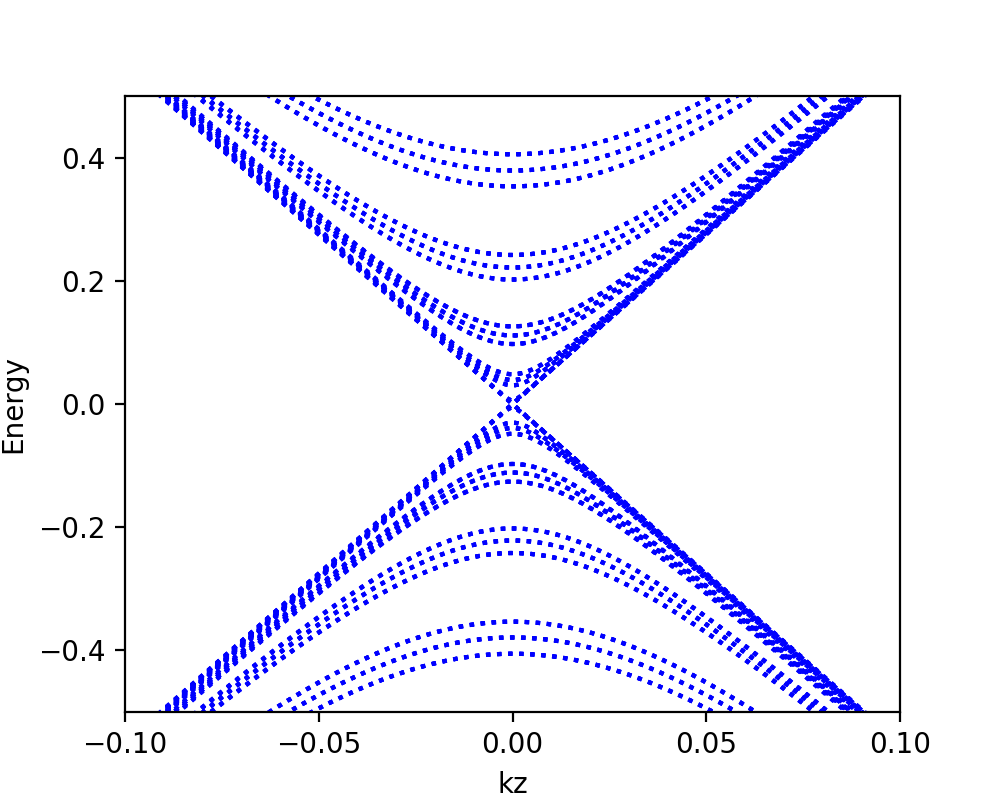

In [49]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

for i in range(0, 4*n):
    ax.plot(kzpt,solution[i,:],'b:')

ax.set_ylim(-0.5,0.5)
ax.set_xlim(-0.1,0.1)

ax.set_ylabel('Energy')
ax.set_xlabel('kz')

ax.set_xticks([-0.1,-0.05,0.0,0.05,0.1])

plt.show()

In [50]:
HamBuild(kzpt[3], n, n)

array([[ 0.      ,  0.      , -0.539294, ...,  0.      , -0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [-0.539294,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ..., 
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
        -0.562226],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      , -0.      ,  0.      , ..., -0.562226,  0.      ,  0.      ]])